# Power Analysis

Using a 2-factor mixed ANOVA on the between-subjects factor condition assignment and within-subjects factor evidence level, what sample size do we need to achive $\beta=0.2$ given a [small-medium effect size](http://methods.sagepub.com/Reference//the-sage-encyclopedia-of-communication-research-methods/i4505.xml) on the affirmation rate of rumours (${\eta^2=0.03}$) *with mixed ANOVA the true effect is closer to $\eta^2=0.08$ indicating a medium-large effect size, which seems more accurate*?

> power is simply the proportion of times that we are able to reject the null hypothesis (remembering that we control the population means and we know that there is a true difference)

* [Article](http://www.discoveringstatistics.com/docs/answertomixedanovaguidedexample.pdf) on mixed ANOVA's 
* [Article](https://guides.library.lincoln.ac.uk/c.php?g=110730&p=4638036) on reporting mixed ANOVA's

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_style("whitegrid",{'axes.spines.left' : False,
                           'axes.spines.right': False,
                           'axes.spines.top': False,
                           'grid.linestyle': ':'})
sns.set_context("talk")
fp = "../data/artifacts/power_simulation-alpha=0.05.csv"

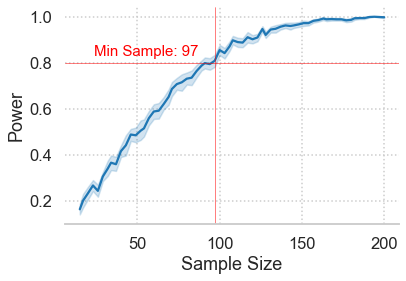

In [19]:
power_sim = pd.read_csv(fp)
g = sns.lineplot(data=power_sim,
                 x="sample_size",
                 y="power")
thresh = power_sim.groupby("sample_size")["power"].mean()
sample_size = thresh[thresh >= 0.8].head(1).index[0]
g.set(xlabel="Sample Size",
      ylabel="Power")
g.axhline(y=0.8,c='red',linewidth=0.5)
g.axvline(x=sample_size,c='red',linewidth=0.5)
# g.figure.savefig("../figures/artifacts/power_simulation-alpha=0.05.pdf",bbox_inches="tight")
# g.text(sample_size-10,
#        0.83,
#        f"Min Sample: {sample_size}",
#        color='red',
#        fontsize="small",
#        horizontalalignment="right")
# g.figure.savefig("../figures/artifacts/power_simulation-alpha=0.05-2.pdf",bbox_inches="tight")

## Simulation

In [5]:
participants = pd.read_csv("../data/processed/mock_data/participant-schema.csv",index_col=0)
posts = pd.read_csv("../data/processed/mock_data/posts-schema.csv",index_col=0)
group_cols = ["PROLIFIC_ID","SESSION_ID","treatment","evidence","code"]
reshare_rates = pd.DataFrame(posts.groupby(group_cols)["reshared"].sum() / posts.groupby(group_cols)["reshared"].count()).reset_index()
# Nicely format labels
reshare_rates['treatment'] = reshare_rates['treatment'].replace({False: 'Control',
                                                                 True: 'Treatment'})
reshare_rates['code'] = reshare_rates['code'].str.title()
reshare_rates["evidence"] = reshare_rates["evidence"].str.title()
reshare_rates = reshare_rates.pivot(index=["PROLIFIC_ID","treatment","evidence"],
                                    columns="code",
                                    values="reshared").reset_index().fillna(0)
reshare_rates

code,PROLIFIC_ID,treatment,evidence,Affirms,Denies,Neutral,Questions
0,1,Treatment,High,0.800000,0.500000,0.0,0.500000
1,1,Treatment,Low,0.250000,1.000000,0.0,0.333333
2,2,Treatment,High,0.333333,0.750000,0.0,0.000000
3,2,Treatment,Low,0.000000,1.000000,1.0,0.000000
4,3,Treatment,High,0.500000,0.000000,0.0,1.000000
...,...,...,...,...,...,...,...
785,497,Treatment,Low,0.333333,1.000000,0.0,0.333333
786,498,Control,High,0.800000,0.666667,0.0,0.500000
787,498,Control,Low,0.600000,0.666667,0.0,0.500000
788,499,Control,High,0.500000,0.333333,0.0,1.000000


In [9]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pingouin import mixed_anova
from tqdm.notebook import tqdm
from numba import jit,njit

@jit
def get_effect(df):
    """
        Gets the effect size, and significance, 
        
        Effect size, eta squared, is derived from this pdf: https://stardock.cs.virginia.edu/empirical/resources/Brown28.pdf
    """
    table = df.mixed_anova(dv='Affirms',
                           between='treatment',
                           within='evidence',
                           subject='PROLIFIC_ID')
    pval = table.iloc[2,6]
    eta_sqr = table.iloc[2,7]
    return eta_sqr,pval

@jit
def power_simulation(df,sample_sizes,num_trials,trial_size,alpha=0.05):
    """
        Conducts a 2-factor mixed ANOVA analaysis given
        returns a dataframe with 3 columns
            sample_size: the sample size for that trial
            power: the proportion of times that treatment*evidence was statistically significant
            avg_eta_sqr: the proportion of variance that treatment*evidence explains in the reshare rate
    """
    # Since there is a within subjects factor (evidence) there are two rows in the dataframe for all participants
    # therefore just sampling the rows would overstate the number of participants needed
    participants = pd.Series(df["PROLIFIC_ID"].unique())
    res = {"sample_size": [],
           "power": [],
           "avg_eta_sqr": []}
    for ss in tqdm(sample_sizes):
        ss = min(ss,len(participants))
        effect_size = 0
        for _ in range(num_trials):
            num_rejections = 0
            for _ in range(trial_size):
                sampled_par = participants.sample(n=ss)
                sampled_df = df[df["PROLIFIC_ID"].isin(sampled_par)]
                eta_sqr, pval = get_effect(sampled_df)
                effect_size += eta_sqr
                if pval < alpha: num_rejections +=1
            res["sample_size"].append(ss)
            res["power"].append(num_rejections/trial_size)
            res["avg_eta_sqr"].append(effect_size/trial_size)
    res = pd.DataFrame(res)
    return pd.DataFrame(res)

In [11]:
eta_sqr, pval = get_effect(reshare_rates)
print(f"Effect size: {eta_sqr:.3f} (p={pval:0.2E})")

Effect size: 0.076 (p=2.61E-08)


In [14]:
sample_sizes = np.linspace(15,200,66,dtype=int)
num_trials = 30
trial_size = 30

power_sim = power_simulation(reshare_rates,
                             sample_sizes,
                             num_trials,
                             trial_size)
power_sim.to_csv(fp,index=False)

  0%|          | 0/66 [00:00<?, ?it/s]